# Milestone-2

**Project:** Monitoring Changes in Surface Water Using Satellite Image Data<br/>
**Deliverable:** Training and test data for image segmenation in order to identify water bodies in satellite images.

## Overview

Labels for segmentation task are image masks identifying the objects in the image. In our case the objects of interest are lakes and/or water bodies. We had few dataset at our disposal through `Sentinel-2` and `NWPU-RESISC45`. The guide notebook provided the workflow for data download such as Google Drive link to the above two data sources selected for this milestone and the process to organize the data relevant to the task. I've consolidated the output of this data into a hierarchy that I would be using in this notebook and which is explained in the README file. Please make sure that the main directory is called `Data` at the same level as this notebook or change the variable name `data_dir` to reflect a different path.

To accomplish the current objective of creating training and validating data, following steps are undertaken:

1. Data Acquisition:

    Within the `Data` directory, there are two more directories that needs to be provided, `Images`, and `Labels`. Images further contains sub-directory named after the data source that it contains, e.g. NWPU sub-directory has images from the RESISC45 dataset.

    `Labels` contains the json file with information on each image. The keys in json file are the names of each image. The hierarchy for Labels follows the same pattern as the Images directory.

     The program looks for labels.json in the expected hierarchy. We are specifically interested in the water regions.

    This prepared Data gets downloaded via a script here but it can also be downloaded manually from [GDrive link](https://drive.google.com/file/d/1V4V4dFvb0V22d4dTLo3U6e4EjVrtnSoV/view?usp=sharing)


2. Data Consolidation:

    All the json file are read one dictionary called `aggregated_labels`. Each image name is stored in `labels_list`, and the image is stored in `image_list`as numpy array. The images are read into the memory using `rasterio`. 
    

3. Mask Creation:

   The labels for each image contains polygon identifying the water region in that image. We create a new empty image as mask with those polygon drawn in it. These masks are then written to disk in the directory `Data/Masks`.
   

4. Test and Validation Set:
        
    The images and masks are further resized to be of the same shape to be used as input in the data augmentation step.

    `train_test_split` is used to split training and testing dataset.


5. Data Augmentation:

    `ImageDataGenerator` is used for creating real-time augmented data from the training set.

## Imports

In [94]:
import os
import json
import shutil
import tarfile
import rasterio
import numpy as np

from random import seed
from random import sample
from PIL import Image, ImageDraw
from rasterio.plot import reshape_as_image
from sklearn.model_selection import train_test_split

from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib.image as MImage

from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

## Data Acquisition

Download the data.

In [ ]:
%run ../Scripts/download_script.py -i '1V4V4dFvb0V22d4dTLo3U6e4EjVrtnSoV' -d 'Data.tar.xz'

Extract the directory.

In [57]:
with tarfile.open("Data.tar.xz") as tarf:
    tarf.extractall()

Setting variables to be used later.

In [58]:
data_dir = 'Data/'
images_dir = data_dir + 'Images/'
labels_dir = data_dir + 'Labels/'
masks_dir = data_dir + 'Masks/'

context_dir= data_dir + 'Context/'
mask_prefix = 'mask_'

labels_json = 'labels.json'

image_width = 256
image_height = 256

Get all the json files in the directory `Data/Labels/<Sub-directory for each source>/labels.json`.

In [59]:
json_files = []
for dir in os.listdir(labels_dir):
    path_to_json = labels_dir + dir + '/'+labels_json
    json_files.append(path_to_json)

In [60]:
json_files

['Data/Labels/NWPU/labels.json', 'Data/Labels/S2_Cloudless/labels.json']

Utility method to read image into the numpy array as image.

In [61]:
def get_raster_image_from_path(path):
    with rasterio.open(path) as r:
        return reshape_as_image(r.read())

The following code goes through each json file. Read keys which are the names of the images for which we have annotation available. Creates a new key name with the name of the source appended to it. This new key name is also appended to `labels_list` so that we have an array of just the image names/labels to traverse. The index of which is also set in `aggregated_labels` dictionary with the rest of the data associated with the original key.

Numpy array as image is retrieved for each of the available annotated label and appended to `image_list`. Because both `labels_list` and `image_list` are done in the same order, the indices corresponds to the same image.

In [62]:
aggregated_labels = dict()

image_list = []
labels_list = []
index = 0

for j in json_files:
    with open(j) as f:
        d  = json.loads(f.read())
        for k in d.keys():
            prefix = j.split('/')[-2]
            new_key = prefix + '_' + k
            aggregated_labels[new_key] = d[k]
            aggregated_labels[new_key]['reverse_index'] = index
            labels_list.append(new_key)
            image_path = images_dir + prefix + '/' + k
            raster_image = get_raster_image_from_path(image_path)
            image_list.append(raster_image)
            index += 1

## Data Inspection

Check a single image and label to see how they appear

In [63]:
labels_list[3]

'NWPU_lake_203.jpg'

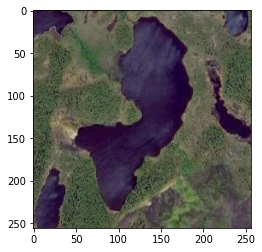

In [65]:
plt.imshow(image_list[3])

Length of the labels_list is equal to the number of available annotated images.

In [64]:
len(labels_list)

692

### Water region outline

Following methods are utilities to retrieve polygons for water regions and to display it as overlay on the original image

In [96]:
def display_image(img, title, num, X, Y, axes = None, a = 1.0):
    """Display image with polygon drawn over it.
    
    Parameters:
    
    img (numpy array): Image array to be shown
    title (string): Title to be displayed on the axes
    num (int): Number of polygon arrays. Pass 0 for none
    X (array): 2-D array containing x co-ordinates for the polygons.
    Y (array): 2-D array containing y co-ordinates for the polgyons.
    """

    ref = None
    if axes == None:
        ref = plt
        if title != None:
            ref.title(title)
    else:
        ref = axes
        if title != None:
            axes.set_title(title)

    ref.imshow(img, alpha = a)
    for i in range(0, num):
        x = X[i]
        y = Y[i]
        ref.plot(x, y)

Utility method to get all the polygon regions and return it as 2-D arrays

In [97]:
def get_polygon(key, info):
    """Retrieve polygon regions from the dictionary.
    
    Parameters:
    info (dictionary): The aggregated_labels dictionary.
    key (string): Top level key i.e the name of the image.

    Returns:
    2-D arrays of X and Y corresponding to the water region.
    """

    regions = info[key]['regions']
    X = []
    Y = []
    count = len(regions)
    for i in regions:
        x = regions[i]['shape_attributes']['all_points_x']
        y = regions[i]['shape_attributes']['all_points_y']
        X.append(x)
        Y.append(y)
    return X, Y, count

Example display showing the image with water region outlined

(1, 64)

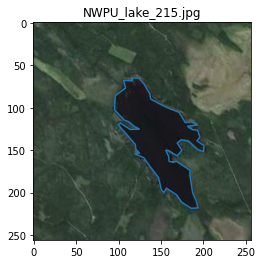

In [98]:
i = 15
X, Y, count = get_polygon(labels_list[i], aggregated_labels)
display_image(image_list[i], labels_list[i], count, X, Y)
display(np.shape(X))

Randomly select images and display them with overlay to visually inspect the dataset. Make sure the images below have water regions correctly outlined.

In [99]:
seed(2)

In [100]:
num_selection = 6

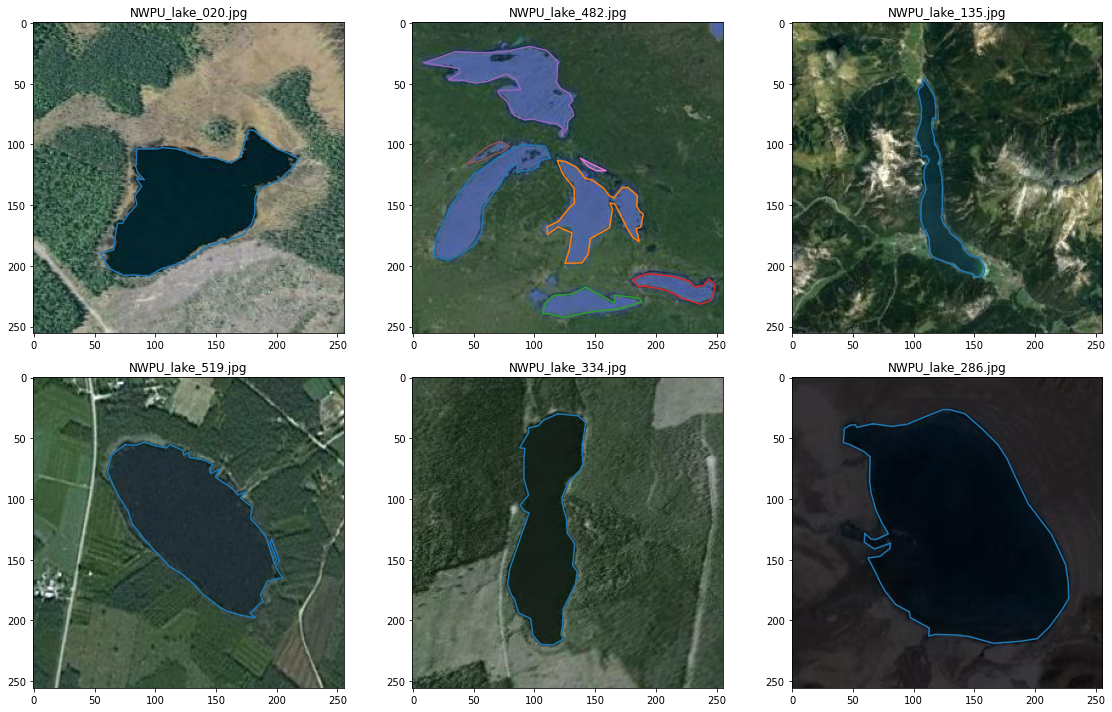

In [136]:
def display_sample(num_selection, labels = labels_list, images = image_list, aggregated = aggregated_labels, 
                   mask_generator = None, overlay_lake = False):

    sample_indices = sample(range(0, len(labels)), num_selection)

    _, axs = plt.subplots(2, 3, figsize = (16, 10))
    axs = axs.flatten()

    for i in range(0, num_selection):
        index = sample_indices[i]
        X = None
        Y = None
        count = 0
        if mask_generator or overlay_lake:
            X, Y, count = get_polygon(labels[index], aggregated)
        display_image(images[index], labels[index], count, X, Y, axs[i])
        if mask_generator != None:
            mask = mask_generator(index)
            display_image(mask, None, 0, None, None, axs[i], a = 0.5)
    plt.tight_layout()

display_sample(num_selection, overlay_lake = True)

## Masks Creation

The `generate_mask` creates a new empty PIL image. Each polygon is an array in the 2-D arrays X and Y. The np.vstack is used with order `F` resulting in the order: x1, y1, x2, y2, ...... xn, yn. This is then drawn over the newly created image. Once all of the polygons are drawn, the image is converted to a numpy array.

In [139]:
def image_mask_for_index(index, images = image_list, labels = labels_list):
    X, Y, count = get_polygon(labels_list[index], aggregated_labels)
    mask = generate_mask(image_list[index], X, Y)
    return mask

In [132]:
def generate_mask(img, X, Y):
    """Generate a mask for the given image from the X and Y co-ordinates representing the polygon
    """
    nx, ny, nz = np.shape(img)
    img = Image.new('L', (nx, ny), 0)
    for x, y in zip(X, Y):
        polygon = np.vstack((x, y)).reshape((-1,),order='F').tolist()
        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    mask = np.array(img)
    return mask

In [133]:
def display_image_with_mask_on_graph(image, mask):
    """Display the original image, the mask, and then the image with the mask overlay.
    """
    _, axs = plt.subplots(1, 3, figsize = (15, 5))
    axs[0].imshow(image)
    axs[1].imshow(mask)
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha = 0.45)

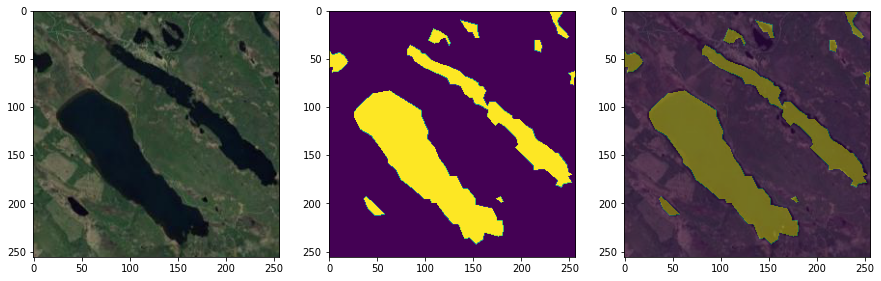

In [144]:
i = aggregated_labels['NWPU_lake_315.jpg']['reverse_index']

mask = image_mask_for_index(i)

def display_image_and_mask(index, mask,
                           labels = labels_list, aggregated = aggregated_labels, images = image_list):
    """Display images by calling display_image_with_mask_on_graph with the image at the provided index
    """
    display_image_with_mask_on_graph(images[index], mask)

display_image_and_mask(i, mask)

Visually inspect the images and mask. Every run should generate graph from randomly selected indices.

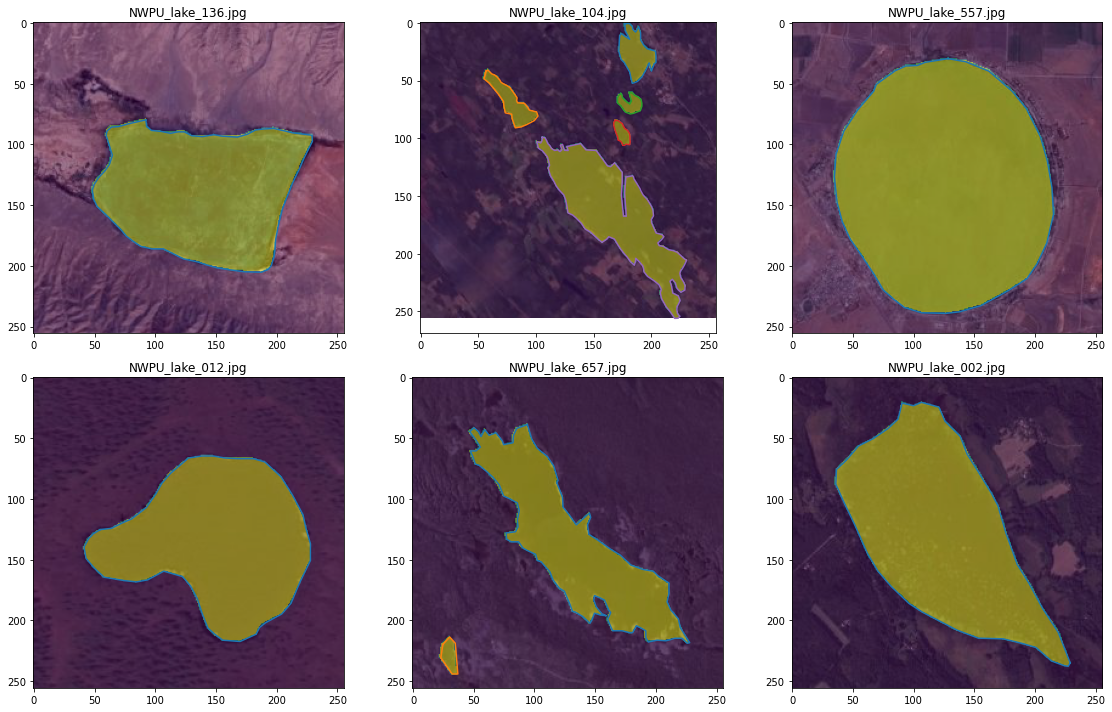

In [147]:
display_sample(num_selection, overlay_lake = False, mask_generator = image_mask_for_index)

### Write masks to disk

Create masks for all annotated images and write to disk.

In [148]:
def create_and_persist_masked_images(labels = labels_list, images = image_list, aggregated = aggregated_labels, 
                                     masks_dir = masks_dir,
                                     index = None, count = None):

    """Create masks for all the images. This method will only process images from the list for which no mask is 
    created yet.
    
    Parameters:
    index (int): Index from which to strart traversing the labels list.
    count (int): Number of labels to traverse, if not needing to traverse all of the labels.
    """
    def create_output_directory(masks_dir):
         if os.path.isdir(masks_dir) == False:
            os.mkdir(masks_dir)

    def write_mask_to_disk(label, aggregated, image, path):
        X, Y, count = get_polygon(label, aggregated)
        mask = generate_mask(image, X, Y)
        MImage.imsave(path, mask)

    create_output_directory(masks_dir)

    start = 0
    end = len(labels)
    if index:
        start = index
    if count:
        end = start + count
    display('#### Saving images to disk ####')
    for i in range(start, end):
        label = labels[i]
        mask_path = masks_dir + mask_prefix + label
        if os.path.exists(mask_path):
            continue
        write_mask_to_disk(label, aggregated, image_list[i], mask_path)
    return True

In [149]:
create_and_persist_masked_images()

'#### Saving images to disk ####'

True

Load the masked image from the disk.

In [150]:
def load_masked_image(label):
    """ Load the masked image for the label
    
    Parameter:
    label (string): The labels from the labels_list. It should not contain the actual name of the masked image
    because the name is auto-generated.
    """

    path = masks_dir + mask_prefix + label
    if os.path.exists(path) == False:
        return None
    return get_raster_image_from_path(path)

Check mask and image from the disk.

In [151]:
aggregated_labels['NWPU_lake_201.jpg']['reverse_index']

1

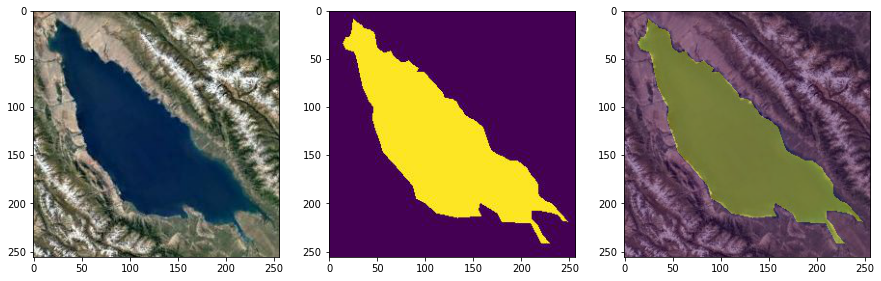

In [152]:
label = 'NWPU_lake_061.jpg'
mask = load_masked_image(label)
display_image_and_mask(aggregated_labels[label]['reverse_index'], mask)

Create an image list for the masks in the same order as labels.

In [167]:
def create_masks_image_list(labels = labels_list):
    """ Load mask images from the disk and store it in a list in the same order as labels
    """
    
    masks_list = []
    for label in labels:
        mask = load_masked_image(label)
        assert mask is not None
        masks_list.append(mask)
    return masks_list

In [154]:
masks_list = create_masks_image_list(labels_list)

Display image with the mask for comparison

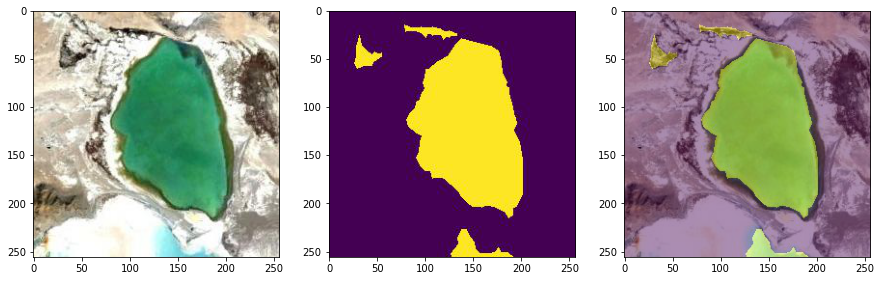

In [155]:
display_image_and_mask(7, masks_list[7])

Display randomly selected images with the mask loaded from disk

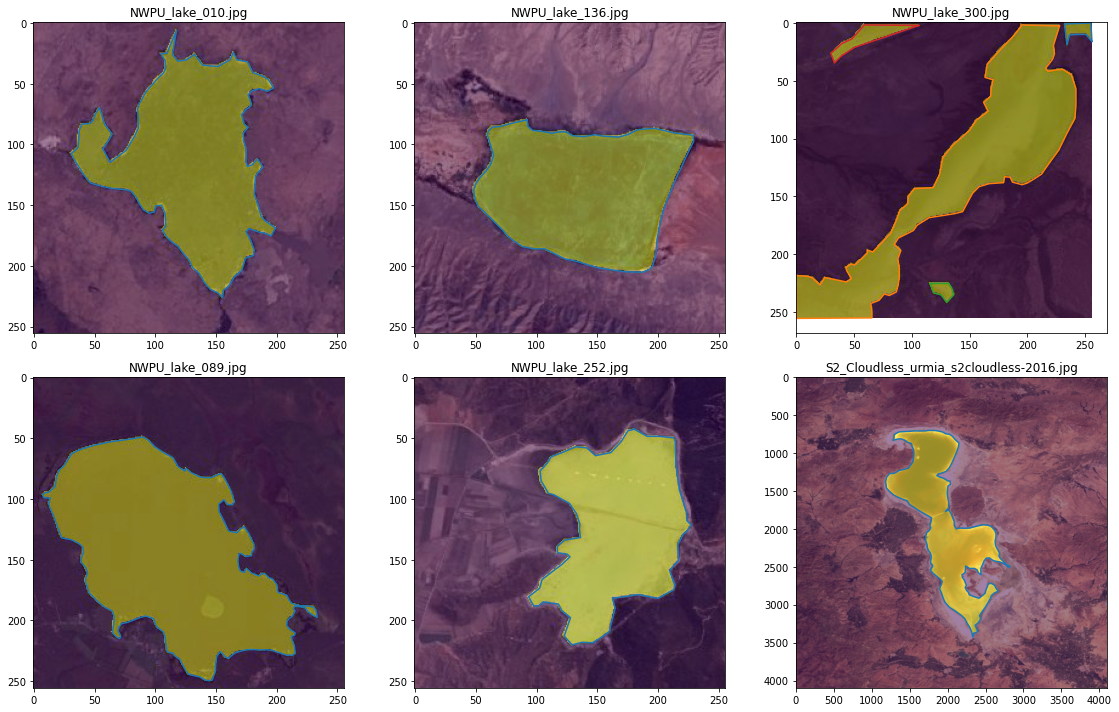

In [156]:
def sample_mask_generator(index, images = masks_list):
    return masks_list[index]

display_sample(6, mask_generator = sample_mask_generator)

## Training and Testing Dataset Creation

X is the input images and y is the masked images 

In [157]:
X = image_list
y = masks_list

The images are resized so that they can later be stacked for input to data augmentor.

In [158]:
import skimage.transform as st

resized_X = [st.resize(img, (image_width, image_height)) for img in X]
resized_y = [st.resize(img, (image_width, image_height)) for img in y]

See how things look after the resize

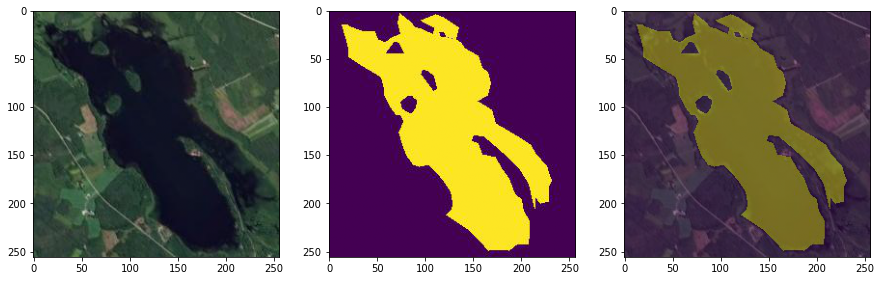

In [159]:
index = 578
display_image_with_mask_on_graph(resized_X[index], resized_y[index])

### Split data for training and testing

In [160]:
X_train, X_test, y_train, y_test = train_test_split(resized_X, resized_y, test_size = 0.30)

In [161]:
display(f'X_train size = {np.shape(X_train)[0]}, y_train size = {np.shape(y_train)[0]}')
display(f'X_test size = {np.shape(X_test)[0]}, y_test size = {np.shape(y_test)[0]}')

'X_train size = 484, y_train size = 484'

'X_test size = 208, y_test size = 208'

Stack the train data so it is in 4-tuple format

In [163]:
xg = np.stack(X_train)
yg = np.stack(y_train)

### Augment Data

Augment the training data with real time transformation to avoid overfitting

In [162]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

In [164]:
datagen.fit(xg)

In [165]:
it = datagen.flow(xg, yg, batch_size=1)

Only the input xg is augmented so the training label may not overlap perfectly.

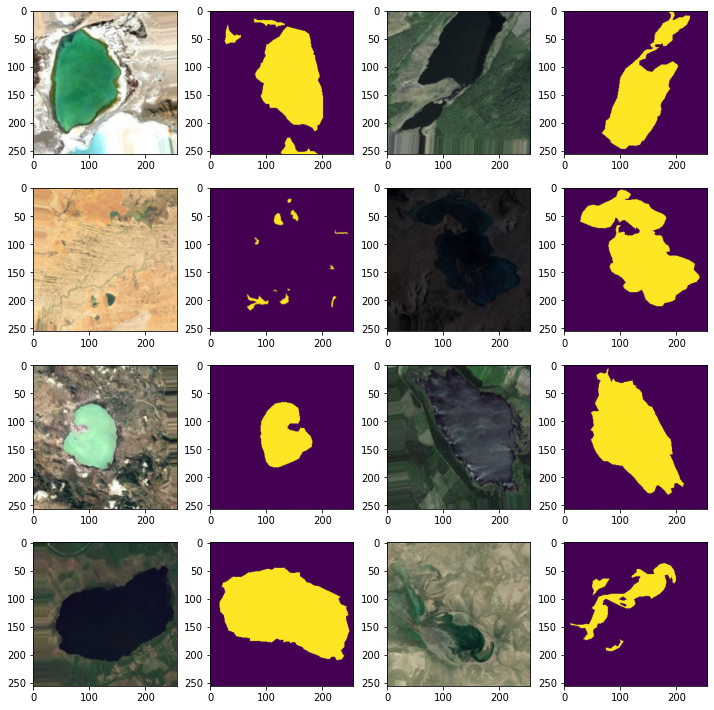

In [166]:
_, axs = plt.subplots(4, 4, figsize = (10, 10))
axs = axs.flatten()

for i in range(0, 16, 2):
    x, y = it.next()
    axs[i].imshow(x[0])
    axs[i+1].imshow(y[0])

plt.tight_layout()